
This pipeline combines existing modules to create a streamlined 21cm observation framework. It currently includes the following steps:
1. Generate 21cm brightness temperature cubes using *21cmFAST*.
2. Construct lightcones with *tools21cm*.
3. Simulate telescope noise with *tools21cm*.
4. Add and remove foregrounds by incorporating the *GSM16* model and performing PCA-based foreground removal.
5. Compute summary statistics, including the 1D/2D power spectrum, bispectrum, and scattering transform. 


In [2]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import tools21cm as t2c 
import py21cmfast as p21c
from py21cmfast import cache_tools
p21c.config['direc'] = '/data73/suice/data/21cmdata/21cmcache'
cache_tools.clear_cache(direc="/data73/suice/data/21cmdata/21cmcache")

sys.path.append('/home/suice/workspace/sdc/21cmPipeline')

## Generate Coeval Boxes

In [2]:
from pipe21cm.signal.run_21cm import run_coeval_bt

In [8]:
#set redshifts
zs = np.arange(6,10.1,0.2).tolist()


# generating 21cm signal at various redshifts
# for tests we use smaller box
box_size = 128
cell_dim = 64
coevals= run_coeval_bt(redshift=zs, 
                        box_size=box_size, 
                        cell_dim=cell_dim, 
                        save_dir='/home/suice/workspace/sdc/sdc_data/test2/')

# 21cmfast config for sdc
# run_coeval_bt(redshift=zs, 
#               box_len=700, 
#               cell_dim=350, 
#               save_dir='/home/suice/workspace/sdc/sdc_data/700mpc')

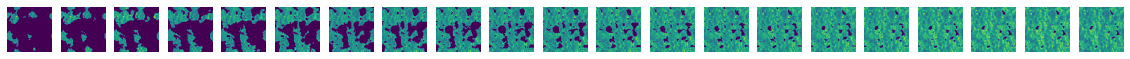

In [9]:
#plot all boxs for each redshift
plt.figure(figsize=(20, 2))
for i in range(len(zs)):
    plt.subplot(1, len(zs), i+1)
    plt.imshow(coevals[i][32])
    plt.axis('off')


## Generate Lightcone

In [10]:
from glob import glob 
from natsort import natsorted
from pipe21cm.signal.lightcone import build_physical_lightcone,build_observational_lightcone

In [11]:
file_list = natsorted(glob('/home/suice/workspace/sdc/sdc_data/test2/*'))

#build lightcones 
lc_physical,lc_zs = build_physical_lightcone(file_list=file_list, 
                                                redshifts=np.array(zs), 
                                                box_size=box_size)

#build observational lightcones
lc_obs, lc_freqs = build_observational_lightcone(file_list=file_list, 
                                                redshifts=np.array(zs), 
                                                box_size=box_size)

Making lightcone between 6.000000 < z < 9.999369


100%|██████████| 630/630 [00:00<00:00, 5808.00it/s]


...done
Making lightcone between 6.000000 < z < 9.999369


100%|██████████| 630/630 [00:00<00:00, 6783.05it/s]


...done


100%|██████████| 738/738 [00:00<00:00, 793.16it/s]


In [12]:
from pipe21cm.utils import plot_lightcone

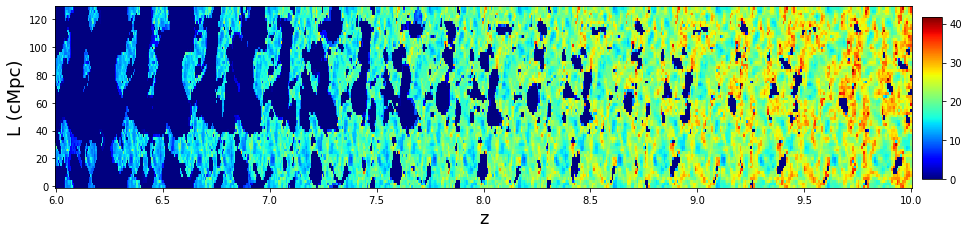

In [13]:
plot_lightcone(lc_physical, lc_zs, box_size)

0.8577008672037477


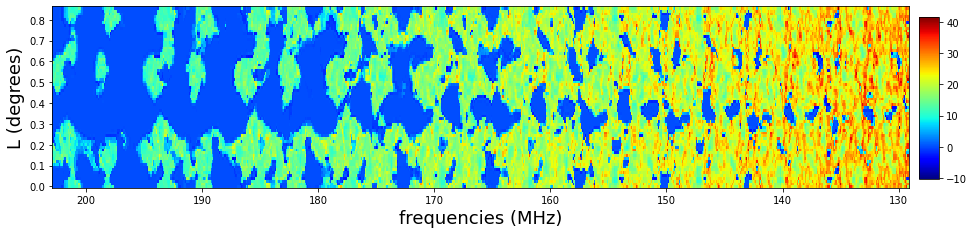

In [14]:
max_deg = np.max(t2c.angular_size_comoving(box_size, lc_zs))
print(max_deg)
plot_lightcone(lc_obs, lc_freqs, max_deg, type='observational')

## Telescope noise

In [17]:
z_obs = t2c.nu_to_z(lc_freqs)

In [ ]:
# generate noise lightcone using tools21cm, this will take some time
noise_lc = t2c.noise_lightcone(ncells=lc_obs.shape[0],
                            zs=z_obs,
                            obs_time=1000,
                            boxsize=box_size,
                            total_int_time=6.0,
                            int_time=10.0,
                            declination=-30.0,
                            n_jobs=16)
    

In [22]:
# noise_lc = np.load('/home/suice/workspace/sdc/sdc_data/obs/noise_lc_128mpc.npy')

In [20]:
lc_ns = lc_obs + noise_lc

lc_ns,smoothed_zs = t2c.smooth_lightcone(lc_ns,z_obs,box_size_mpc=box_size,max_baseline=2) 

100%|██████████| 738/738 [00:00<00:00, 3410.60it/s]


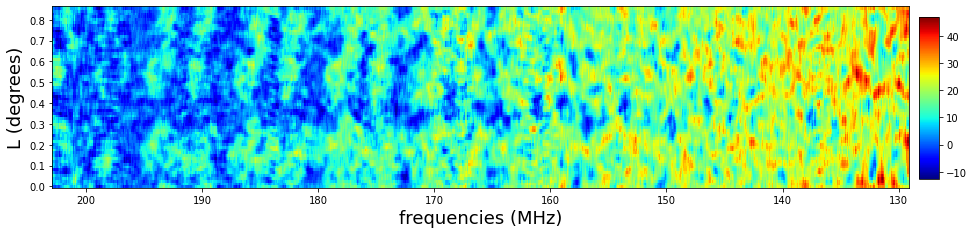

In [21]:
plot_lightcone(lc_ns, lc_freqs, max_deg, type='observational')

## Foreground

In [4]:
from pipe21cm.foreground.galatic import generate_GSM_cube

In [6]:
fg_lc = generate_GSM_cube(degree=0.86, box_dim=64, freqs=lc_freqs)

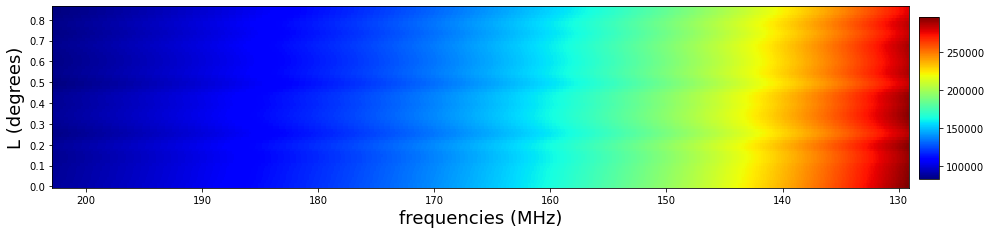

In [27]:
plot_lightcone(fg_lc, lc_freqs, max_deg, type='observational')

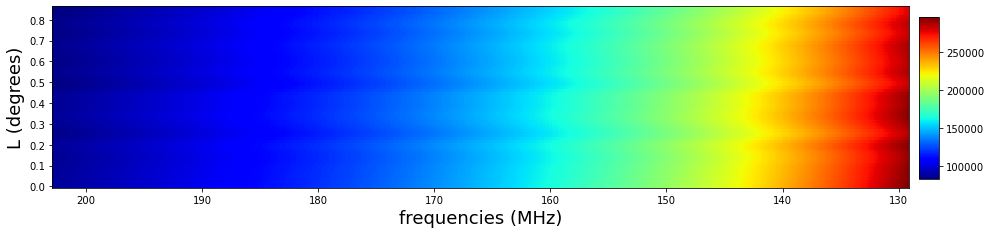

In [28]:
lc_final = lc_ns + fg_lc

plot_lightcone(lc_final, lc_freqs, max_deg, type='observational')

In [42]:
from pipe21cm.foreground.removal import pca_removal

In [43]:
#try to remove foregrounds using PCA
final_signal = pca_removal(lc_final, n_components=5)

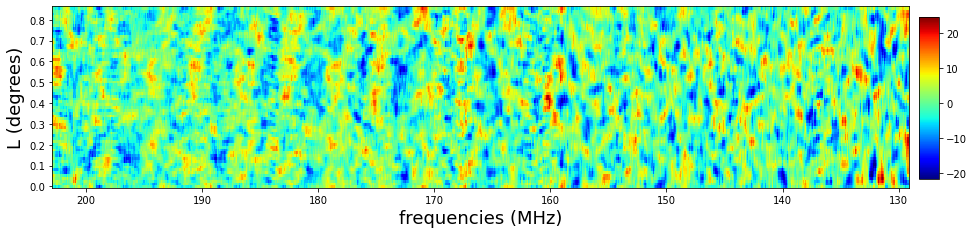

In [44]:
plot_lightcone(final_signal, lc_freqs, max_deg, type='observational')

## Summary Statistics

In [45]:
from pipe21cm.summary.power_spectrum import calculate_1dpk,calculate_2dpk
from pipe21cm.summary.bispectrum import caculate_icoBk
from pipe21cm.summary.scattering_transform import ScatteringTransformKernel

In [46]:
# 1dps, bs, st are calculated for each coeval box
cube = coevals[0]

nkbins = 15
ks,pk = calculate_1dpk(cube,box_size=128,kbins=nkbins)
k1,k3,icoBk = caculate_icoBk(cube,box_size=128,kbins=ks)

st_k = ScatteringTransformKernel(J=5, L=5, shape=(64,64,64))
st_coef = st_k.get_compact_coef(cube)

Text(0.5, 1.0, 'Scattering Transform')

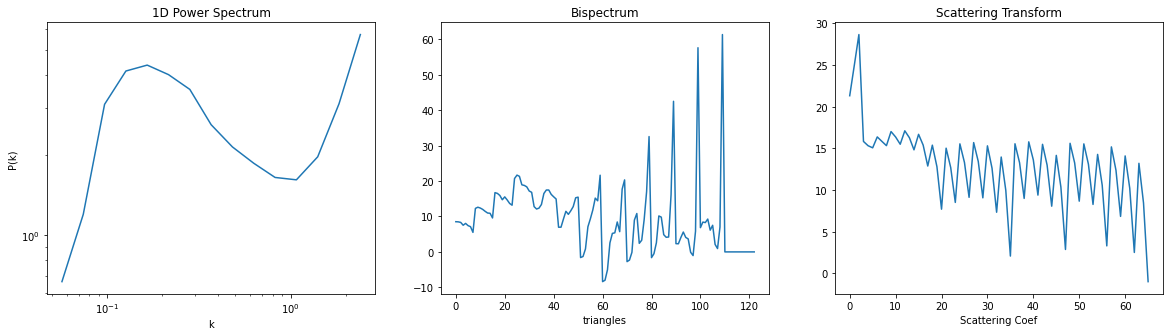

In [48]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.loglog(ks,pk)
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('1D Power Spectrum')

plt.subplot(1, 3, 2)
plt.plot(icoBk)
plt.xlabel('triangles')
plt.title('Bispectrum')

plt.subplot(1, 3, 3)
plt.plot(st_coef)
plt.xlabel('Scattering Coef')
plt.title('Scattering Transform')

In [49]:
# 2dps are calculated for the lightcone

kper_mid, kpar_mid, p2d = calculate_2dpk(lc_physical, box_size=128, kbins=nkbins)

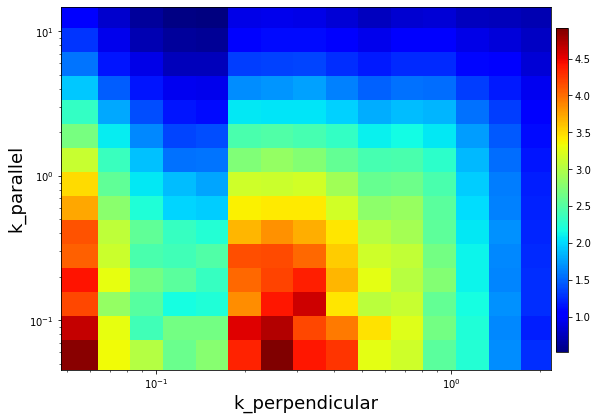

In [50]:
#plot 2D power spectrum
fig, axs = plt.subplots(1,1, figsize=(8, 6))
im = axs.pcolor(kper_mid, kpar_mid, np.log10(p2d), cmap='jet')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('k_perpendicular', fontsize=18)
axs.set_ylabel('k_parallel', fontsize=18)
#add colorbar
fig.subplots_adjust(bottom=0.11, right=0.91, top=0.95, left=0.06)
cax = plt.axes([0.92, 0.15, 0.02, 0.75])
fig.colorbar(im,cax=cax)